- Import necessary packages.

In [1]:
import torch
import wandb
import numpy as np
import transformers as tr
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader

import json
import gc
from pathlib import Path
from typing import Dict, List, Union

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

- Setup necessary paths.

In [2]:
DATA_ROOT = Path(r'') 
OUTPUT_DIR = Path(r'')

- Create configuration dictionary for hyperparameters and other relevant information

In [3]:
CONFIG = {
    'training': {
        'resume_artifact': 'suciucezar07/detr/model-in8k822y:v0',    # resume training from this artifact
        'max_epochs': 2,            # maximum number of epochs to train for
        'batch_size': 1,            # batch size for each split's dataloader
        'num_workers': 0,           # number of workers for each split's dataloader
        'unfreeze_epoch': 1,        # unfreeze entire model at the start of this epoch
        'overfit_batches': 10,      # use only if you want to overfit for debugging, otherwise set to 0
        
        'model': {
            'lr': 1e-4,             # lr set for encoder-decoder
            'lr_backbone': 1e-5,    # lr set for backbone
            'weight_decay': 1e-4,   # weight decay
        }
    },
    
    'project': 'detr'               # wandb project name
}

TRAIN_DICT = CONFIG['training']
MODEL_DICT = TRAIN_DICT['model']

- Utility class for Cityscapes in COCO Detection format.

In [4]:
class CityscapesDetectionAPI:

    def __init__(self, root: Path, annFile: Path):
        self.root = root
        self.annFile = annFile

        if not self.annFile.exists():
            raise FileNotFoundError(f'Annotation file not found at {self.annFile}.')

        print(f'[INFO] loading annotations into memory from {self.annFile.name}...')
        with open(self.annFile, 'r') as f: self.annotations = json.load(f)
        print('done!')

        print('creating index...')
        self.categories = self.annotations['categories']
        for cat in self.categories: cat['hasInstances'] = bool(cat['hasInstances'])
        self.images = self.annotations['images']
        self.annotations = self.annotations['annotations']
        print('index created!')

    def __getitem__(self, image_id):
        return self.loadImgs(image_id)[0], self.loadAnn(image_id)
    
    def getImageIds(self) -> List[int]:
        return [img['id'] for img in self.images]

    def getCategory(self, category_id) -> Dict[str, any]:
        return next((cat for cat in self.categories if cat['id'] == category_id), None)
    
    def loadAnn(self, image_id: int) -> List[Dict[str, any]]:
        return [ann for ann in self.annotations if ann['image_id'] == image_id]

    def loadImgs(self, image_ids: Union[List[int], int]) -> List[Image.Image]:
        if isinstance(image_ids, int):
            image_ids = [image_ids]
        return [Image.open(self.root / img['file_name']) for img
                in list(filter(lambda img: img['id'] in image_ids, self.images))]
    
    def showAnns(self, image: Image.Image, anns: List[Dict[str, any]], 
                 include_noInstances: bool = False, copy: bool = False) -> Image.Image:
        image = image.copy() if copy else image
        draw = ImageDraw.Draw(image)
        
        for instance_ann in anns:
            category = self.getCategory(instance_ann['category_id'])
            if not category['hasInstances'] and not include_noInstances:
                continue

            color = tuple(np.random.randint(0, 255, 3))
            x, y, w, h = instance_ann['bbox']
            draw.rectangle([x, y, x + w, y + h], outline=color, width=3)
            draw.text((x, y), category['name'], fill='white', font=ImageFont.truetype("arial.ttf", size=20))

        return image

In [5]:
train_cityscapesAPI = CityscapesDetectionAPI(
    root=DATA_ROOT, annFile=DATA_ROOT / 'annotations' / 'cityscapes_instances_train.json')

[INFO] loading annotations into memory from cityscapes_instances_train.json...
done!
creating index...
index created!


In [6]:
print({cat['id']: cat['name'] for cat in train_cityscapesAPI.categories})

{0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'}


In [7]:
class CollateDetection:

    def __init__(self, processor):
        self.processor = processor

    def __call__(self, batch):
        pixel_values, labels = list(zip(*batch))
        encoding = self.processor.pad(pixel_values, return_tensors="pt")
        return {
            'pixel_values': encoding['pixel_values'],
            'pixel_mask': encoding['pixel_mask'],
            'labels': labels
        }


class CityscapesDetectionDataset(Dataset):

    def __init__(self, cityscapesAPI: CityscapesDetectionAPI, processor=None):
        self.cityscapesAPI = cityscapesAPI
        self.processor = processor

        self.image_ids = self.cityscapesAPI.getImageIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img, target = self.cityscapesAPI[image_id]

        # -------------------------------------------------------
        # DATA AUGMENTATION
        # -------------------------------------------------------

        if self.processor is not None:
            target = {'image_id': image_id, 'annotations': target}
            encoding = self.processor(images=img, annotations=target, return_tensors="pt")

            return encoding["pixel_values"].squeeze(), encoding["labels"][0]

        return img, target


class CityscapesDetectionDataModule(pl.LightningDataModule):

    def __init__(self,
                 root: Path,
                 annFiles: Dict[str, Path],
                 processor=None,
                 batch_size: int = 1,
                 num_workers: int = 0):
        super().__init__()

        self.root = root
        self.cityscapesAPIs = {split: CityscapesDetectionAPI(self.root, annFile) for split, annFile in annFiles.items()}
        self.datasets = {}
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.collate_fn = CollateDetection(processor)

        # metadata related to the dataset
        self.categories = self.cityscapesAPIs['train'].categories
        self.MAX_CLASS_ID = max([cat['id'] for cat in self.categories])

    def setup(self, stage):
        if stage == 'fit':
            for split in ['train', 'val']:
                if split in self.cityscapesAPIs:
                    self.datasets[split] = CityscapesDetectionDataset(
                        cityscapesAPI=self.cityscapesAPIs[split], processor=self.processor)

        if stage == 'test':
            if 'test' in self.cityscapesAPIs:
                self.datasets['test'] = CityscapesDetectionDataset(
                    cityscapesAPI=self.cityscapesAPIs['test'], processor=self.processor)

    def train_dataloader(self):
        if 'train' not in self.datasets:
            return None
        return DataLoader(
            self.datasets['train'],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
            shuffle=True)

    def val_dataloader(self):
        if 'val' not in self.datasets:
            return None
        return DataLoader(
            self.datasets['val'],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn)

    def test_dataloader(self):
        if 'test' not in self.datasets:
            return None
        return DataLoader(
            self.datasets['val'],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn)

- Take a look at the Cityscapes dataset in COCO Detection format

In [8]:
train_dataset = CityscapesDetectionDataset(train_cityscapesAPI)

In [9]:
image, anns = train_dataset[0]

In [10]:
anns[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

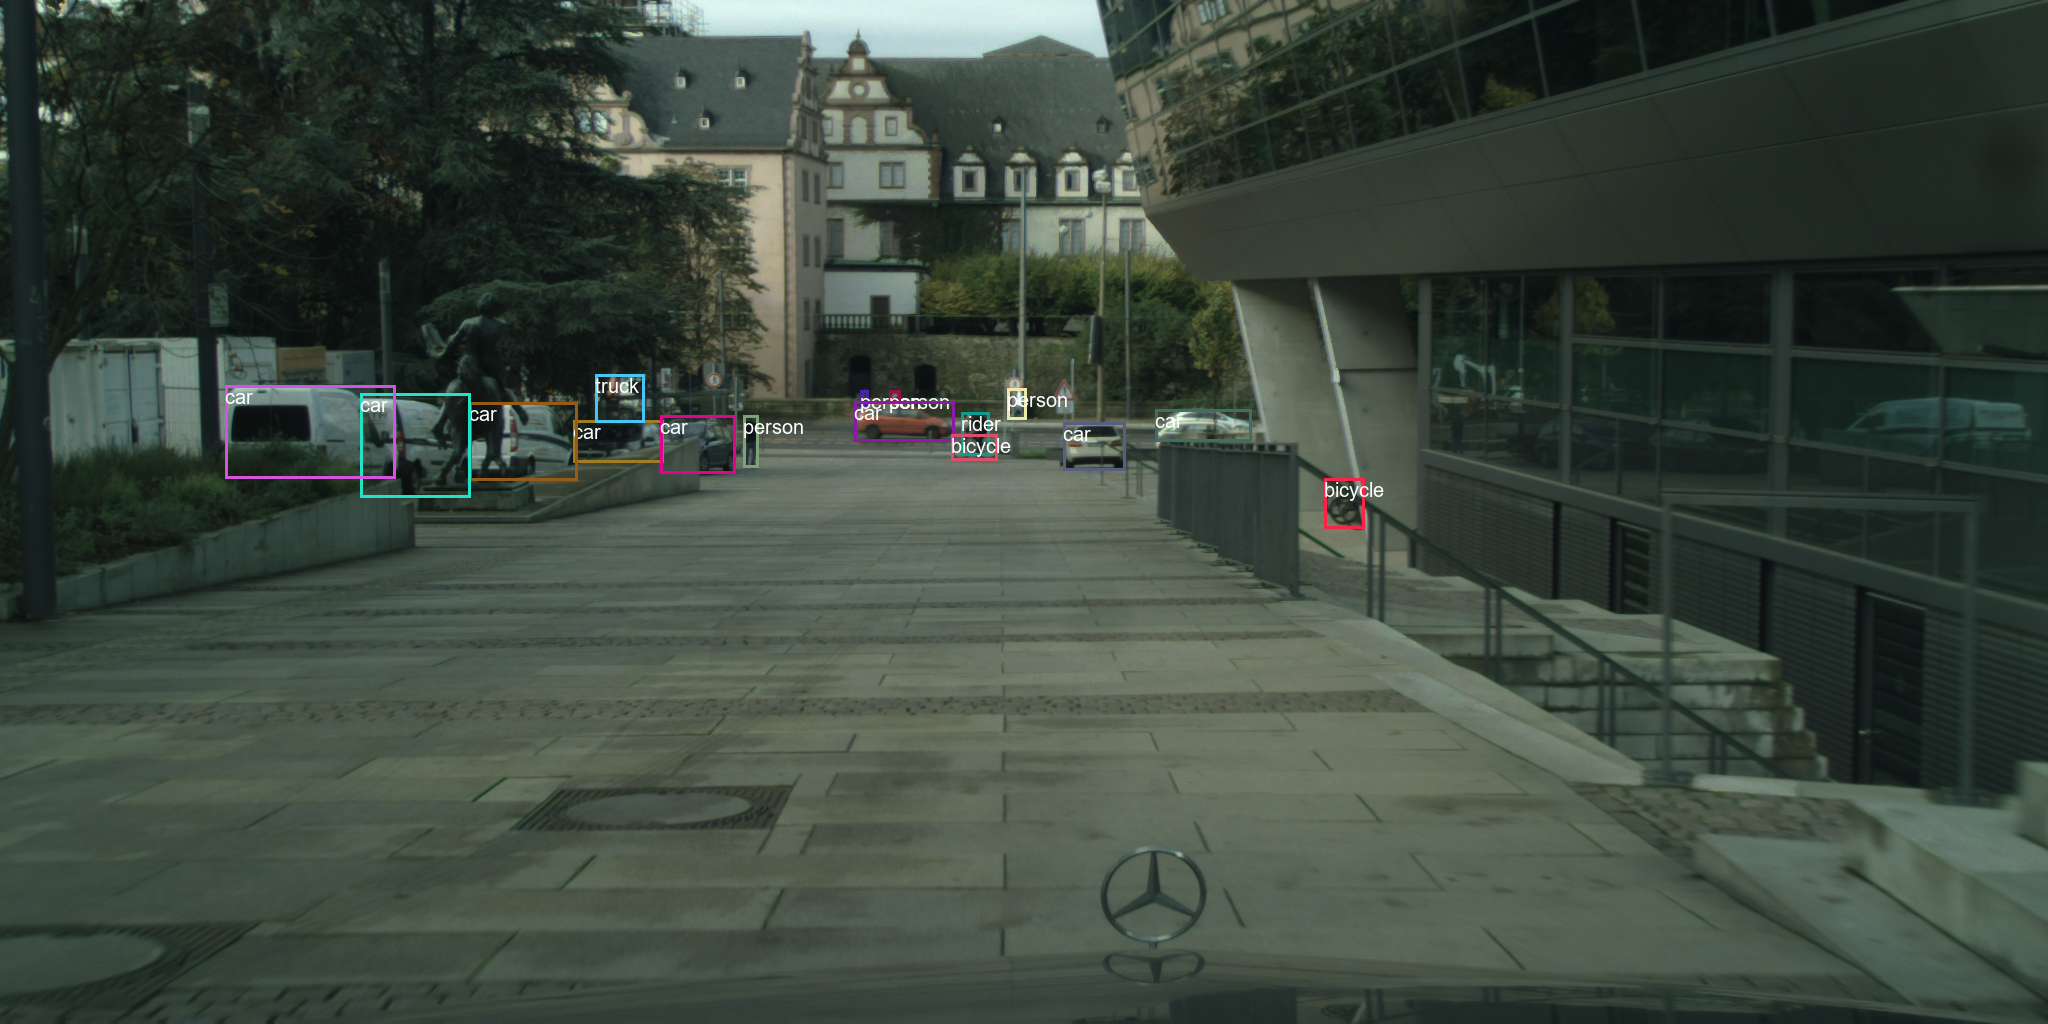

In [11]:
train_dataset.cityscapesAPI.showAnns(image, anns, include_noInstances=False, copy=True)

In [12]:
datamodule = CityscapesDetectionDataModule(
    root=DATA_ROOT, 
    annFiles={
    'train': DATA_ROOT / 'annotations' / 'cityscapes_instances_train.json',
    'val': DATA_ROOT / 'annotations' / 'cityscapes_instances_val.json',
    'test': DATA_ROOT / 'annotations' / 'cityscapes_instances_test.json'
    },
    processor=tr.DetrImageProcessor.from_pretrained("facebook/detr-resnet-50"),
    batch_size=TRAIN_DICT['batch_size'],
    num_workers=TRAIN_DICT['num_workers'])

datamodule.setup('fit')

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


[INFO] loading annotations into memory from cityscapes_instances_train.json...
done!
creating index...
index created!
[INFO] loading annotations into memory from cityscapes_instances_val.json...
done!
creating index...
index created!
[INFO] loading annotations into memory from cityscapes_instances_test.json...
done!
creating index...
index created!


In [13]:
batch = next(iter(datamodule.train_dataloader()))

In [14]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [15]:
batch['pixel_values'].shape, batch['pixel_mask'].shape

(torch.Size([1, 3, 666, 1332]), torch.Size([1, 666, 1332]))

In [16]:
batch['labels'][0].keys()

dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])

- Create a callback which will unfreeze the entire the model at the beginning of a given epoch.

In [17]:
class UnfreezeCallback(pl.Callback):

    def __init__(self, unfreeze_epoch, lr, lr_backbone, weight_decay):
        self.unfreeze_epoch = unfreeze_epoch
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == self.unfreeze_epoch:
            # unfreeze the entire module
            pl_module.unfreeze()
            # update the optimizer
            param_dicts = [
                {"params": [p for n, p in trainer.model.named_parameters() if "backbone" not in n and p.requires_grad]},
                {
                    "params": [p for n, p in trainer.model.named_parameters() if "backbone" in n and p.requires_grad],
                    "lr": self.lr_backbone,
                },
            ]
            optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
            trainer.optimizers = [optimizer]

            print(f"[INFO] Unfreezing the entire model at epoch {self.unfreeze_epoch}.")

In [18]:
class DetectionModel(pl.LightningModule):

    def __init__(self, max_class_id: int, lr=1e-4):
        super(DetectionModel, self).__init__()
        self.lr = lr
        self.detr = tr.DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50",
            num_labels=max_class_id + 1,
            ignore_mismatched_sizes=True)

        # freeze all modules except the classification head
        self.detr.model.requires_grad_(False)
        self.detr.bbox_predictor.requires_grad_(False)
        self.detr.class_labels_classifier.requires_grad_(True)

        self.save_hyperparameters()

    def forward(self, pixel_values, pixel_mask, labels=None):
        return self.detr(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.detr(**batch)

        self.log('train/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        for k, v in outputs['loss_dict'].items():
            self.log(f'train/{k}', v, on_step=True, on_epoch=True, sync_dist=True)

        return outputs['loss']

    def validation_step(self, batch, batch_idx):
        outputs = self.detr(**batch)

        self.log('val/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        for k, v in outputs['loss_dict'].items():
            self.log(f'val/{k}', v, on_step=True, on_epoch=True, sync_dist=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.detr.parameters(), lr=self.lr)

    def unfreeze(self):
        for param in self.detr.parameters():
            param.requires_grad = True

In [19]:
wandb_logger = pl.loggers.WandbLogger(project=CONFIG['project'], log_model=True)

In [20]:
wandb_logger.experiment.config.update(TRAIN_DICT)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: suciucezar07. Use `wandb login --relogin` to force relogin


In [21]:
unfreeze_callback = UnfreezeCallback(
    unfreeze_epoch=TRAIN_DICT['unfreeze_epoch'],
    lr=MODEL_DICT['lr'],
    lr_backbone=MODEL_DICT['lr_backbone'],
    weight_decay=MODEL_DICT['weight_decay'])

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val/loss', 
    mode='min', 
    dirpath=OUTPUT_DIR / 'checkpoints' if OUTPUT_DIR else None)

In [22]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=TRAIN_DICT['max_epochs'],
    logger=wandb_logger,
    callbacks=[checkpoint_callback, unfreeze_callback],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
    overfit_batches=TRAIN_DICT['overfit_batches'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
if TRAIN_DICT['resume_artifact']:
    artifact_dir = wandb_logger.download_artifact(
        artifact=TRAIN_DICT['resume_artifact'],
        save_dir=OUTPUT_DIR / 'artifacts' if OUTPUT_DIR else None,
        artifact_type='model')
    model = DetectionModel.load_from_checkpoint(Path(artifact_dir) / 'model.ckpt')
else:
    model = DetectionModel(max_class_id=datamodule.MAX_CLASS_ID, lr=MODEL_DICT['lr'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [24]:
wandb_logger.watch(model, log='all')

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [25]:
torch.cuda.empty_cache()
gc.collect()

40

In [26]:
trainer.fit(model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type                   | Params
------------------------------------------------
0 | detr | DetrForObjectDetection | 41.5 M
------------------------------------------------
5.1 K     Trainable params
41.5 M    Non-trainable params
41.5 M    Total params
166.025   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[INFO] Unfreezing the entire model at epoch 1.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [27]:
wandb.finish()

- Inference + Visualization

In [28]:
def drawDetections(image: Image.Image, detections: List, include_noInstances: bool = False, copy: bool = False):
    image = image.copy() if copy else image
    draw = ImageDraw.Draw(image)
    
    for score, category, (xmin, ymin, xmax, ymax) in detections:
        if category['hasInstances'] == False and include_noInstances == False:
            continue
        
        name, color = category['name'], tuple(np.random.randint(0, 255, 3))
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=3)
        text = f'{name} {score:0.2f}'
        draw.text((xmin, ymin), text, fill='white', font=ImageFont.truetype("arial.ttf", size=20))
    
    return image

In [29]:
val_iter = iter(datamodule.val_dataloader())
processor = datamodule.val_dataloader().dataset.processor

In [30]:
inputs = next(val_iter)

In [31]:
with torch.no_grad():
    outputs = model(inputs['pixel_values'].to(model.device), inputs['pixel_mask'].to(model.device))

In [32]:
image_ids = [label['image_id'] for label in inputs['labels']]
target_sizes = [label['orig_size'] for label in inputs['labels']]

decoded_outputs = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)
images = datamodule.cityscapesAPIs['val'].loadImgs(image_ids)

In [33]:
img_output_pairs = iter(zip(images, decoded_outputs))
NO_OBJECT_ID = datamodule.MAX_CLASS_ID + 1

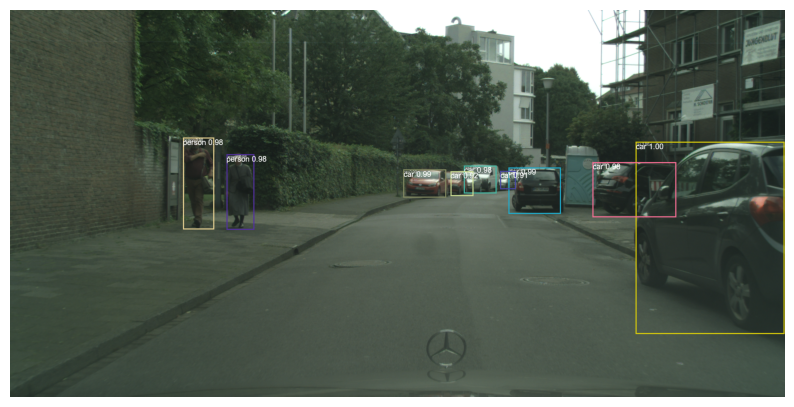

In [43]:
image, output = next(img_output_pairs)

detections = list(zip(output['scores'].tolist(), output['labels'].tolist(), output['boxes'].tolist()))
detections = list(filter(lambda x: x[1] != NO_OBJECT_ID, detections))

if len(detections) > 0:
    categories = [datamodule.cityscapesAPIs['val'].getCategory(d[1]) for d in detections]
    scores, labels, boxes = list(zip(*detections))
    detections = list(zip(scores, categories, boxes))
    
img_show = drawDetections(image, detections, include_noInstances=True, copy=True)

plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.axis('off')
plt.show()